# Calculate CMIP Indeces

This file 
1. calculates all the 'traditional' indeces defined in utils/_indexDefinitions for all months for all models.
2. it then averages the result over the warm season
3. and figures out what years there are compounding events



In [1]:
#import my functions
import helpers.fileHandler as fh
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
import utils.sstIndex as sst
import utils.pslIndex as psl
import utils.timePeriod as tp
import utils.compound as compound


In [2]:
import xarray
import numpy
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
modelSet=_model.scenarioMip

In [7]:
experimentSet=_model.experimentSet

# 1. Calculate CMIP Indeces

For each experiment and model, calculate indices

This grabs the monthly CESM indeces, and calculates the averages for the time periods of interest (aka the warm season), as set in the _indexDefitionions file

Theres a few examples of output at the bottom to sanity check this is meaningful

The indeces for each month have already been calculated. So loading up the saved versions, and putting them into a single xarray.

In [8]:
for experiment in experimentSet: 
    print(experiment)
    timePIndeces=list()

    for model in _model.scenarioMip[:,1]:
        try:
            indecesDs = xarray.open_dataset('results/cmipWarmSeasonIndeces/' + model +'tos'+ experiment + '.nc')
            indecesDs['model']=model
            timePIndeces.append(indecesDs)
        except Exception as e:
            print('skipping' + model + experiment) 
    results=xarray.concat(timePIndeces, 'model')

    results=results.assign_attrs({'experiment':experiment,**indecesDs.attrs,**_index.monthsOfInterest})

    results.to_netcdf('results/cmip6'+experiment+'TradIndecesTos.nc')

piControl
historical
ssp126
skippingCAS-ESM2-0ssp126
skippingCESM2ssp126
skippingCanESM5-CanOEssp126
skippingEC-Earth3-CCssp126
skippingGFDL-CM4ssp126
skippingHadGEM3-GC31-LLssp126
skippingHadGEM3-GC31-MMssp126
skippingMPI-ESM1-2-HRssp126
ssp245
skippingCAS-ESM2-0ssp245
skippingCESM2ssp245
skippingHadGEM3-GC31-LLssp245
skippingHadGEM3-GC31-MMssp245
skippingMPI-ESM1-2-HRssp245
ssp370
skippingCAS-ESM2-0ssp370
skippingCESM2ssp370
skippingCIESMssp370
skippingCanESM5-CanOEssp370
skippingEC-Earth3-CCssp370
skippingFIO-ESM-2-0ssp370
skippingGFDL-CM4ssp370
skippingHadGEM3-GC31-LLssp370
skippingHadGEM3-GC31-MMssp370
skippingMPI-ESM1-2-HRssp370
skippingNESM3ssp370
ssp585


Some sanity checks to see if it looks ok:


In [9]:
results=xarray.open_dataset('results/cmip6ssp585TradIndecesTos.nc').sel(year=slice(1850,2099))

In [10]:
str(results.isel(model=6).model.values)

'CESM2'

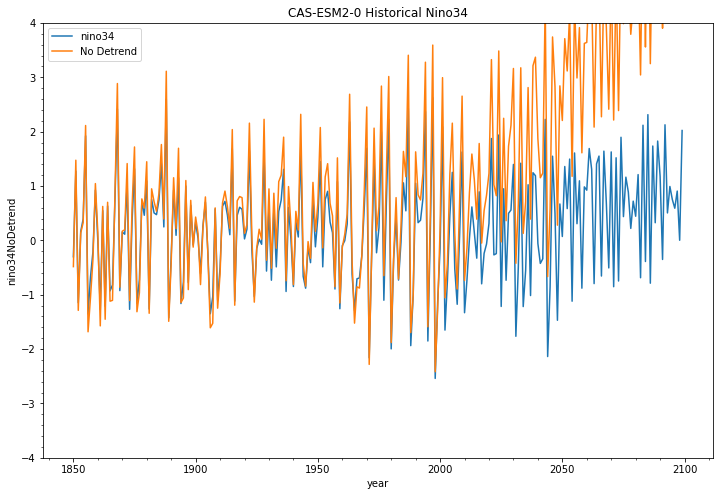

In [11]:
# plotSomething
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

results.isel(model=6).nino34.plot(label='nino34')
results.isel(model=6).nino34NoDetrend.plot(label='No Detrend')

#Tidy up a bit
plt.title(str(results.isel(model=5).model.values) + " Historical Nino34")
plt.ylim(-4,4)
plt.minorticks_on()
plt.legend()

In [12]:
# A multi-model mean?

mean = results.sam.mean(dim='model')
std = results.sam.std(dim='model')

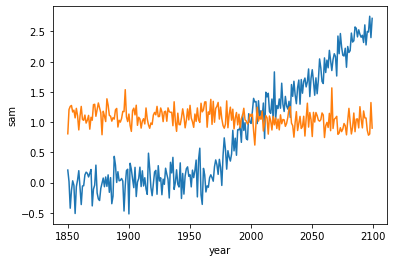

In [13]:
plt.figure()
mean.plot()
std.plot()

# 2. Calculate Compound Years for CESM6

# Define a criteria to determine events

So we are going to define events as follows:
- For SST indeces (aka Enso and Iod), this is 1 sigma above/below mean
- For PSL indeces (aka Sam) this is 0.5 sigma above/below mean

Using a piControl climatology

In [14]:
piControlXr=xarray.open_dataset('results/cmip6piControlTradIndecesTos.nc')


In [15]:
# This should calculate stds for all models and all indeces
stdXr = piControlXr.std(dim='year')

# define some criteria that we want to use to identifiy it thats an event
criteriaXr= xarray.merge(
    (stdXr[['nino34','dmi']], stdXr['sam']/2)
)

In [16]:
criteriaXr

<xarray.Dataset>
Dimensions:  (model: 38)
Coordinates:
  * model    (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
Data variables:
    nino34   (model) float64 0.7126 0.5657 0.6957 0.8038 ... 1.11 0.9918 0.7418
    dmi      (model) float64 0.4608 0.6935 0.2474 ... 0.5769 0.5068 0.6175
    sam      (model) float64 0.6323 0.6126 0.548 0.5631 ... 0.5571 0.5387 0.5739

# Calculate the compounding years and plot an example

Events are split into fire promoting, or not-fire promiting and compound years found

In [17]:
firePos=list()
fireNeg=list()

#for every experiment
for experiment in experimentSet:

    # Here is the data
    indecesXr = xarray.open_dataset('results/cmip6'+experiment+'TradIndecesTos.nc')

    # Determine events by the criteria found above
    firePosByEvent, fireNegByEvent = compound.applyCriteria(indecesXr, criteriaXr)

    # compound, and add to the list
    firePos.append(compound.compound(firePosByEvent))
    fireNeg.append(compound.compound(fireNegByEvent))


#combine by experiment
firePosXr=xarray.concat(firePos, 'experiment')
firePosXr['experiment']=experimentSet
fireNegXr=xarray.concat(fireNeg, 'experiment')
fireNegXr['experiment']=experimentSet

#combine by fire pos/neg
allCompoundsXr=xarray.concat([firePosXr,fireNegXr],'fire')
allCompoundsXr['fire']=['pos','neg']

#save it
allCompoundsXr.to_netcdf('results/cmip6TradCompounds.nc')

firePos: 
['nino34', 'dmi']
fireNeg: 
['sam']
firePos: 
['nino34', 'dmi']
fireNeg: 
['sam']
firePos: 
['nino34', 'dmi']
fireNeg: 
['sam']
firePos: 
['nino34', 'dmi']
fireNeg: 
['sam']
firePos: 
['nino34', 'dmi']
fireNeg: 
['sam']
firePos: 
['nino34', 'dmi']
fireNeg: 
['sam']


In [18]:
allCompoundsXr

<xarray.Dataset>
Dimensions:      (experiment: 6, fire: 2, model: 38, year: 5341)
Coordinates:
  * model        (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * year         (year) int64 1 2 3 4 5 6 7 ... 7888 7889 7890 7891 7892 7893
  * experiment   (experiment) <U10 'piControl' 'historical' ... 'ssp585'
  * fire         (fire) <U3 'pos' 'neg'
Data variables:
    nino34       (fire, experiment, model, year) float64 nan nan nan ... nan nan
    dmi          (fire, experiment, model, year) float64 nan nan nan ... nan nan
    sam          (fire, experiment, model, year) float64 nan nan nan ... nan nan
    nEvents      (fire, experiment, model, year) float64 nan nan nan ... nan nan
    all3         (fire, experiment, model, year) float64 nan nan nan ... nan nan
    nino34+dmi   (fire, experiment, model, year) float64 nan nan nan ... nan nan
    nino34+sam   (fire, experiment, model, year) float64 nan nan nan ... nan nan
    dmi+sam      (fire, experiment, model, year) float64 nan nan nan ... nan nan
    anyCompound  (fire, experiment, model, year) float64 nan nan nan ... nan nan
Attributes:
    all3:     ['nino34', 'dmi', 'sam']
    indeces:  ['nino34', 'dmi', 'sam']
    pairs:    ['nino34+dmi', 'nino34+sam', 'dmi+sam']

Plot an example

Text(0.5, 1.0, 'CIESM: Pairs and all-three compounds for individal years')

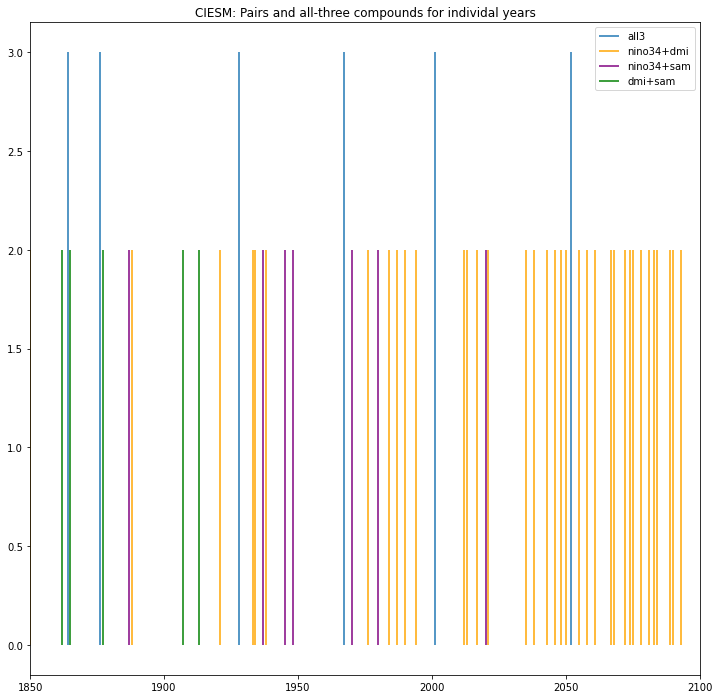

In [19]:
modToPlot = 'CIESM'

toPlot=3*firePosXr.sel(experiment='ssp585').all3.sel(model=modToPlot)

plt.figure(figsize=(12,12))

plt.vlines(
    x=firePosXr.sel(experiment='ssp585').year, 
    ymin=0,
    ymax=toPlot,
    label='all3'
)

colors=['orange', 'purple', 'green']
iCol = 0

for iPair in firePosXr.attrs['pairs']:
    plt.vlines(
        x=firePosXr.sel(experiment='ssp585').year, 
        ymin=0,
        ymax=2*firePosXr[iPair].sel(experiment='ssp585').sel(model=modToPlot),
        color=colors[iCol],
        label=iPair
    )
    iCol+=1
plt.legend()
plt.xlim(1850,2100)
plt.title(modToPlot+': Pairs and all-three compounds for individal years')